In [18]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
import numpy
from xgboost import XGBRegressor

In [19]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('ACB Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df=data.reset_index()['Price']

In [20]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [21]:
#chia train test lúc vẽ sơ đồ
train_size1 = int(0.85 * len(df))
train_data1 = df[:train_size1]
test_data1 = df[train_size1:]

#x_test1 = np.array(test_data1.index).reshape(-1, 1)
#y_test1 = np.array(test_data1)

In [22]:
# 4. Chia train test cho train model
train_size = int(0.85 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [23]:
# 5. Hàm Create Dataset

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [24]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
#X_val, yval = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [25]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

In [26]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
#X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [27]:
# 8. Define LSTM Model

model_lstm=Sequential()
model_lstm.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model_lstm.add(LSTM(50,return_sequences=True))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
# 9. Fit mô hình với dữ liệu train
model_lstm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 3s 57ms/step - loss: 0.0451 - val_loss: 0.0050
Epoch 2/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 3/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 4/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 5/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 6/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 0.0017

In [29]:
# 10. Dự báo dữ liệu test, val
y_pred_lstm=model_lstm.predict(X_test)
#y_pred_val=model.predict(X_val)

y_pred_new_lstm = scaler.inverse_transform(y_pred_lstm.reshape(1, -1))
y_test_new_lstm = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

7/7 [==============================] - 1s 7ms/step


In [30]:
# Chuẩn hóa dữ liệu y_pred_lstm
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

In [31]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse_lstm = np.sqrt(mean_squared_error(y_test_new_lstm, y_pred_new_lstm))
test_score_mape_lstm = mean_absolute_percentage_error(y_test_new_lstm, y_pred_new_lstm) * 100
test_score_mda_lstm = calculate_mda(y_test_new_lstm, y_pred_new_lstm)

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm, '%')
print('MDA trên tập test là:', test_score_mda_lstm, '%')

RMSE trên tập test là: 386.32858
MAPE trên tập test là: 0.9065227583050728 %
MDA trên tập test là: 40.0 %


In [32]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model_lstm.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_lstm.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.6727339]
168
1 day input [0.71477388 0.73792535 0.7356102  0.74950109 0.74718594 0.74718594
 0.74718594 0.75181623 0.75181623 0.75181623 0.74718594 0.75181623
 0.74950109 0.75413138 0.76802226 0.75876167 0.75644653 0.75181623
 0.75876167 0.76107682 0.77033741 0.58512564 0.60364682 0.60133167
 0.60364682 0.60596197 0.59438623 0.59207108 0.58744079 0.59438623
 0.59670138 0.59901653 0.60364682 0.59670138 0.59670138 0.59901653
 0.59670138 0.60827711 0.62448314 0.622168   0.62679829 0.60827711
 0.61522256 0.61522256 0.61290741 0.61059226 0.59901653 0.59901653
 0.61059226 0.61290741 0.60596197 0.61290741 0.61290741 0.61290741
 0.61290741 0.61290741 0.61290741 0.6175377  0.61522256 0.62679829
 0.62679829 0.61985285 0.622168   0.6568952  0.65226491 0.66384064
 0.68004667 0.72403447 0.69393756 0.67773153 0.66847094 0.65458006
 0.65458006 0.6615255  0.65226491 0.65458006 0.64531947 0.60827711
 0.61290741 0.61522256 0.60596197 0.61522256 0.61059226 0.61522256
 0.61522256 0.63374373 0.64068917 

In [33]:
# Chuẩn hóa dữ liệu lst_output
lst_output = scaler.inverse_transform(lst_output)

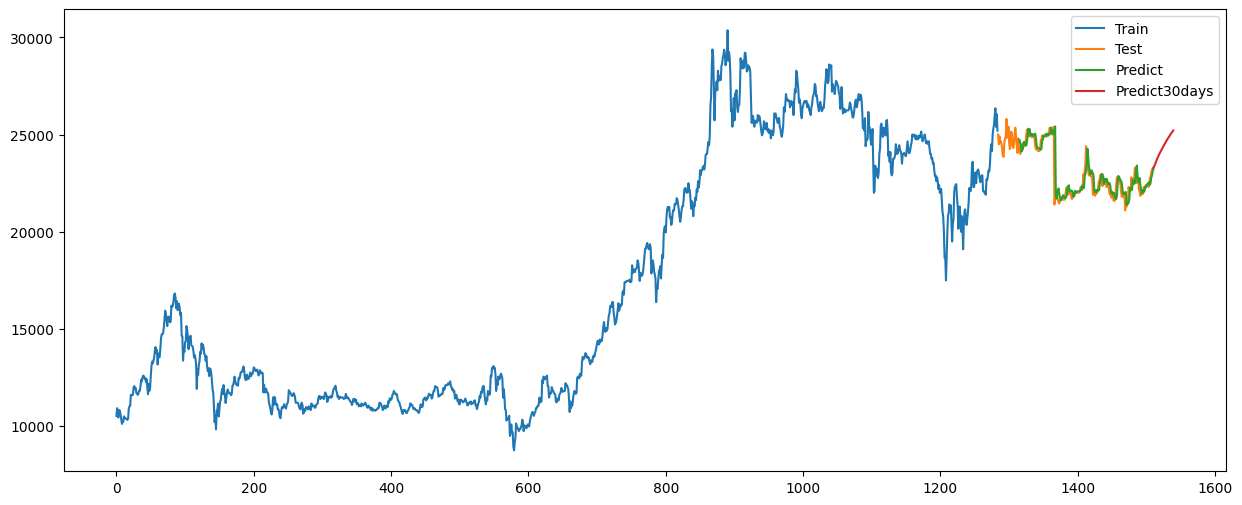

In [34]:
plt.figure(figsize=(15, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,train_data1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_data1)
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_lstm)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index, lst_output)
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()